In [1]:
import pickle

# Load meta dict

with open('../../PNC/MegaMeta.bin', 'rb') as f:
    meta = pickle.load(f)
    
print(len(list(meta.keys())))

941


In [2]:
# Load splits

with open('../../Work/Explainer/Splits/EmoidNbackWrat10FoldCV.pkl', 'rb') as f:
    splits = pickle.load(f)

print('Finished')

Finished


In [3]:
import numpy as np

print(len(np.concatenate([splits[0][0],splits[0][1]])))

def getTrainTestIdcs(splits, splitId, makeTorch=True):
    lookup = dict()
    allSplit0Ids = np.concatenate([splits[0][0],splits[0][1]])
    for i in range(620):
        lookup[allSplit0Ids[i]] = i
    trainIdcs = []
    testIdcs = []
    for key in splits[splitId][0]:
        trainIdcs.append(lookup[key])
    for key in splits[splitId][1]:
        testIdcs.append(lookup[key])
    trainIdcs = np.array(trainIdcs)
    testIdcs = np.array(testIdcs)
    if makeTorch:
        trainIdcs = torch.from_numpy(trainIdcs).cuda()
        testIdcs = torch.from_numpy(testIdcs).cuda()
    return trainIdcs, testIdcs

a,b = getTrainTestIdcs(splits, 4, False)
print(a.shape)
print(b.shape)

(558,)
(62,)


In [4]:
p_nback = np.zeros([620,264,264])
p_emoid = np.zeros([620,264,264])
age_class = np.zeros([620])
ages = np.zeros([620])
sexes = np.zeros([620],dtype='long')

split0Ids = np.concatenate([splits[0][0],splits[0][1]])

for i in np.arange(620):
    subId = split0Ids[i]
    p_nback[i] = np.corrcoef(meta[subId]['nbackData'])
    p_emoid[i] = np.corrcoef(meta[subId]['emoidData'])
    sex = meta[subId]['meta']['Gender']
    if sex == 'M':
        sexes[i] = 0
    elif sex == 'F':
        sexes[i] = 1
    else:
        raise Exception(f'bad sex {sex} for subject {subId}')
    age = int(meta[subId]['meta']['AgeInMonths'])/12
    if age < 8:
        raise Exception(f'bad age {age} for subject {subId}')
    elif age < 12:
        age_class[i] = 0
    elif age < 14:
        age_class[i] = 1
    elif age < 16:
        age_class[i] = 2
    elif age < 18:
        age_class[i] = 3
    elif age < 23:
        age_class[i] = 4
    else:
        raise Exception(f'bad age {age} for subject {subId}')
    ages[i] = age
    if i % 100 == 0:
        print(f'Finished {i}')
        
print(f'Finished train {i}')

Finished 0
Finished 100
Finished 200
Finished 300
Finished 400
Finished 500
Finished 600
Finished train 619


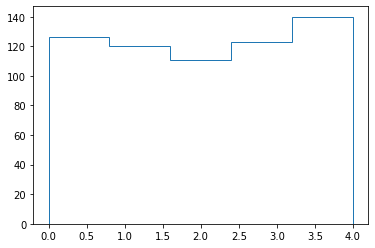

In [5]:
import matplotlib.pyplot as plt

plt.hist(age_class, bins=5, histtype='step')
plt.show()

In [6]:
# Convert to torch

import torch

p_nback_t = torch.from_numpy(p_nback).reshape(-1,264*264).float().cuda()
p_emoid_t = torch.from_numpy(p_emoid).reshape(-1,264*264).float().cuda()
sexes_t = torch.from_numpy(sexes).cuda()
ages_t = torch.from_numpy(ages).float().cuda()

feat_t = torch.cat([p_nback_t, p_emoid_t], dim=1)

print(feat_t.shape)
print('Complete')

torch.Size([620, 139392])
Complete


In [21]:
# For a small train and test set size we can expect accuracy to be between 50-65%

Atrain = calcEdges(feat_t[0:110], feat_t[0:110]) + torch.eye(110).float().cuda()
A = calcEdges(feat_t, feat_t) + torch.eye(620).float().cuda()

print(Atrain.shape)
print(A.shape)

class GCN(nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.gc1 = nn.Linear(2*264*264,100).float().cuda()
        self.gc2 = nn.Linear(100,2).float().cuda()
        self.loss = nn.CrossEntropyLoss()
#             self.loss = nn.MSELoss()

    def forward(self, x):
        A = x[0]
        z = x[1]
        a = A@z
        a = F.relu(self.gc1(a))
        a = A@a
        a = self.gc2(a)
        return a
    
gcn = GCN()
optim = torch.optim.Adam(gcn.parameters(), lr=1e-5, weight_decay=0.2)

nEpoch = 3000 # 2000 for age pred, 3000 for sex classification
pPrint = 200

sexes_t_train = sexes_t[0:110]
ages_t_train = ages_t[0:110]
feat_t_train = feat_t[0:110]

for epoch in range(nEpoch):
    optim.zero_grad()
    pred = gcn([Atrain,feat_t_train]).squeeze()
    loss = gcn.loss(pred, sexes_t_train)
    loss.backward()
    optim.step()
    if epoch % pPrint == 0 or epoch == nEpoch-1:
        print(f'epoch {epoch} loss={loss}')

print(f'Complete GCN quick test')

prob = gcn([A,feat_t]).squeeze()[110:].detach().cpu().numpy()
y = sexes_t[110:].detach().cpu().numpy()
pred = np.argmax(prob, axis=1)
res = np.sum(pred == y)

print(f'Correct {res} out of {y.shape[0]}')
print(f'{res/y.shape[0]}%')

torch.Size([110, 110])
torch.Size([620, 620])
epoch 0 loss=0.7086866497993469
epoch 200 loss=0.5276670455932617
epoch 400 loss=0.3400748074054718
epoch 600 loss=0.2507993280887604
epoch 800 loss=0.19032169878482819
epoch 1000 loss=0.16103608906269073
epoch 1200 loss=0.13406318426132202
epoch 1400 loss=0.1211162582039833
epoch 1600 loss=0.11279167979955673
epoch 1800 loss=0.10442298650741577
epoch 2000 loss=0.09801977872848511
epoch 2200 loss=0.09040134400129318
epoch 2400 loss=0.08180487155914307
epoch 2600 loss=0.07556667178869247
epoch 2800 loss=0.07193608582019806
epoch 2999 loss=0.0698019340634346
Complete GCN 7
Correct 326 out of 510
0.6392156862745098%


In [32]:
# Train the model

import torch.nn as nn
import torch.nn.functional as F

ageCls = 4
outputDir = f'ClassifySex5AgeCategories/AgeGroup{ageCls}'

nCorrectGCN = np.zeros(10)
nCorrectMLP = np.zeros(10)
nTotal = np.zeros(10)

for split in range(10):
    trainIdcsAll, testIdcsAll = getTrainTestIdcs(splits, split, True)
    
    allIdcs = np.argwhere(age_class == ageCls).flatten()
    
    idcs = np.intersect1d(allIdcs, trainIdcsAll.detach().cpu().numpy())
    trainIdcs = torch.from_numpy(idcs).cuda()
    
    idcs = np.intersect1d(allIdcs, testIdcsAll.detach().cpu().numpy())
    testIdcs = torch.from_numpy(idcs).cuda()
    
    idcs = np.argwhere(np.isin(allIdcs, idcs)).flatten()
    testIdcsReindexed = torch.from_numpy(idcs).cuda()
    
    allIdcs = torch.from_numpy(allIdcs).cuda()

    def normalize(A):
        if A.shape[0] != A.shape[1]:
            raise Exception("Bad A shape")
        d = torch.sum(A,dim=1)**0.5
        return ((A/d).T/d).T

    # Cosine similarity
    def calcEdges(ps1, ps2):
        nB = ps1.shape[0]
        e = torch.einsum('ai,bi->ab',ps1,ps2)
        F1 = torch.einsum('ai,ai->a',ps1,ps1)**0.5
        F2 = torch.einsum('ai,ai->a',ps2,ps2)**0.5
        e /= F1.unsqueeze(1)
        e /= F2.unsqueeze(1).T
    #     e = torch.einsum('aij,bij->ab',ps1,ps2)
    #     F1 = torch.einsum('aij,aij->a',ps1,ps1)**0.5
    #     F2 = torch.einsum('aij,aij->a',ps2,ps2)**0.5
    #     e /= F1.unsqueeze(1)
    #     e /= F2.unsqueeze(1).T
        return normalize(e-torch.eye(nB).float().cuda())

    Atrain = calcEdges(feat_t[trainIdcs], feat_t[trainIdcs]) + torch.eye(trainIdcs.shape[0]).float().cuda()
    A = calcEdges(feat_t[allIdcs], feat_t[allIdcs]) + torch.eye(allIdcs.shape[0]).float().cuda()

    print(Atrain.shape)
    print(A.shape)

    class GCN(nn.Module):
        def __init__(self):
            super(GCN, self).__init__()
            self.gc1 = nn.Linear(2*264*264,100).float().cuda()
            self.gc2 = nn.Linear(100,2).float().cuda()
            self.loss = nn.CrossEntropyLoss()
#             self.loss = nn.MSELoss()

        def forward(self, x):
            A = x[0]
            z = x[1]
            a = A@z
            a = F.relu(self.gc1(a))
            a = A@a
            a = self.gc2(a)
            return a

    gcn = GCN()
    optim = torch.optim.Adam(gcn.parameters(), lr=1e-5, weight_decay=0.2)

    nEpoch = 3000 # 2000 for age pred, 3000 for sex classification
    pPrint = 200

    sexes_t_train = sexes_t[trainIdcs]
    ages_t_train = ages_t[trainIdcs]
    feat_t_train = feat_t[trainIdcs]

    for epoch in range(nEpoch):
        optim.zero_grad()
        pred = gcn([Atrain,feat_t_train]).squeeze()
        loss = gcn.loss(pred, sexes_t_train)
        loss.backward()
        optim.step()
        if epoch % pPrint == 0 or epoch == nEpoch-1:
            print(f'epoch {epoch} loss={loss}')

    print(f'Complete GCN {split}')
    
    torch.save(gcn.state_dict(), f'../../Work/Explainer/Models/{outputDir}/gcn{split}.pkl')
    
    prob = gcn([A,feat_t[allIdcs]]).squeeze()[testIdcsReindexed].detach().cpu().numpy()
    y = sexes_t[testIdcs].detach().cpu().numpy()
    pred = np.argmax(prob, axis=1)
    res = np.sum(pred == y)

    print(f'Correct {res} out of {y.shape[0]}')
    
    nCorrectGCN[split] = res
    
    class MLP(nn.Module):
        def __init__(self):
            super(MLP, self).__init__()
            self.fc1 = nn.Linear(2*264*264,100).float().cuda()
            self.fc2 = nn.Linear(100,2).float().cuda()
            self.loss = nn.CrossEntropyLoss()
#             self.loss = nn.MSELoss()

        def forward(self, x):
            x = F.relu(self.fc1(x))
            x = self.fc2(x)
            return x

    mlp = MLP()
    optim = torch.optim.Adam(mlp.parameters(), lr=2e-5, weight_decay=0.2)

    nEpoch = 1000
    pPrint = 200

    for epoch in range(nEpoch):
        optim.zero_grad()
        pred = mlp(feat_t_train).squeeze()
        loss = mlp.loss(pred, sexes_t_train)
        loss.backward()
        optim.step()
        if epoch % pPrint == 0 or epoch == nEpoch-1:
            print(f'epoch {epoch} loss={loss}')

    print(f'Complete MLP {split}')
    
    torch.save(mlp.state_dict(), f'../../Work/Explainer/Models/{outputDir}/mlp{split}.pkl')

    prob = mlp(feat_t[allIdcs]).squeeze()[testIdcsReindexed].detach().cpu().numpy()
    y = sexes_t[testIdcs].detach().cpu().numpy()
    pred = np.argmax(prob, axis=1)
    res = np.sum(pred == y)

    print(f'Correct {res} out of {y.shape[0]}')
    
    nCorrectMLP[split] = res
    nTotal[split] = y.shape[0]
    
print(nCorrectGCN)
print(nCorrectMLP)
print(nTotal)

torch.Size([130, 130])
torch.Size([140, 140])
epoch 0 loss=0.6879032850265503
epoch 200 loss=0.412393182516098
epoch 400 loss=0.2272118777036667
epoch 600 loss=0.15324009954929352
epoch 800 loss=0.1275622695684433
epoch 1000 loss=0.11700189858675003
epoch 1200 loss=0.10889285057783127
epoch 1400 loss=0.10081732273101807
epoch 1600 loss=0.0956365093588829
epoch 1800 loss=0.0906781554222107
epoch 2000 loss=0.08545796573162079
epoch 2200 loss=0.08087798953056335
epoch 2400 loss=0.07457595318555832
epoch 2600 loss=0.07153423130512238
epoch 2800 loss=0.06909450888633728
epoch 2999 loss=0.06668110191822052
Complete GCN 0
Correct 7 out of 10
epoch 0 loss=0.7037715315818787
epoch 200 loss=0.06136135011911392
epoch 400 loss=0.043328657746315
epoch 600 loss=0.03817896544933319
epoch 800 loss=0.035882458090782166
epoch 999 loss=0.033946555107831955
Complete MLP 0
Correct 7 out of 10
torch.Size([125, 125])
torch.Size([140, 140])
epoch 0 loss=0.6848324537277222
epoch 200 loss=0.318599671125412
epoc

epoch 800 loss=0.08087141811847687
epoch 1000 loss=0.07171343266963959
epoch 1200 loss=0.0662323608994484
epoch 1400 loss=0.06225023791193962
epoch 1600 loss=0.05937856808304787
epoch 1800 loss=0.056283123791217804
epoch 2000 loss=0.05446283891797066
epoch 2200 loss=0.0706624984741211
epoch 2400 loss=0.06198384240269661
epoch 2600 loss=0.056919705122709274
epoch 2800 loss=0.054728180170059204
epoch 2999 loss=0.05402395501732826
Complete GCN 9
Correct 14 out of 18
epoch 0 loss=0.6916165947914124
epoch 200 loss=0.05448877066373825
epoch 400 loss=0.04162682592868805
epoch 600 loss=0.036715298891067505
epoch 800 loss=0.033692821860313416
epoch 999 loss=0.032551299780607224
Complete MLP 9
Correct 14 out of 18
[ 7. 13.  7.  9. 12. 11. 12. 13.  5. 14.]
[ 7. 12.  7. 10. 12. 11. 12. 14.  5. 14.]
[10. 15. 10. 18. 16. 16. 15. 16.  6. 18.]


In [33]:
np.sum(nCorrectGCN)/np.sum(nTotal)

0.7357142857142858

In [34]:
np.sum(nCorrectMLP)/np.sum(nTotal)

0.7428571428571429